In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv1D,Conv2D, Dense, Flatten, MaxPooling1D, MaxPooling2D, AveragePooling2D
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import calendar
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling1D, Concatenate
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Layer, MultiHeadAttention, LayerNormalization, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error
import time 

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
#!pip install xgboost

In [4]:
#import yfinance as yf
#sp500 = "^NSEI"
#data = yf.download(sp500, start="2021-01-02", end="2024-11-30")
#data.to_csv("data/nifty50_historical_data_21_24.csv")

In [41]:
df_train_all = pd.read_csv("data/nifty50_historical_data_21_24.csv")

In [42]:
df_train_all.columns

Index(['Date', 'Adj_Close', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')

In [43]:
df_train_all["Date"] = pd.to_datetime(df_train_all["Date"])

In [44]:
df_train_all.describe()

,Adj_Close,Close,High,Low,Open,Volume
count,965.000000,965.000000,965.000000,965.000000,965.000000,9.650000e+02
mean,18796.638030,18796.638030,18890.909429,18695.065531,18806.976788,3.187171e+05
std,2981.551086,2981.551086,2988.481866,2978.348139,2982.247429,1.363069e+05
min,13634.599609,13634.599609,13898.250000,13596.750000,13758.599609,0.000000e+00
25%,16912.250000,16912.250000,17037.599609,16788.599609,16876.650391,2.388000e+05
50%,17936.349609,17936.349609,18034.099609,17846.150391,17939.349609,2.815000e+05
75%,20901.150391,20901.150391,20941.250000,20769.500000,20929.750000,3.603000e+05
max,26216.050781,26216.050781,26277.349609,26151.400391,26248.250000,1.103600e+06


In [45]:
df_train_all.isnull().sum()

Date         0
Adj_Close    0
Close        0
High         0
Low          0
Open         0
Volume       0
dtype: int64

In [46]:
type(df_train_all["Date"])

pandas.core.series.Series

In [47]:
df_train_all["epoch_time"]= df_train_all["Date"].apply(lambda x: x.timestamp())

In [48]:
df_train_all

,Date,Adj_Close,Close,High,Low,Open,Volume,epoch_time
0,2021-01-04 00:00:00+00:00,14132.900391,14132.900391,14147.950195,13953.750000,14104.349609,495000,1.609718e+09
1,2021-01-05 00:00:00+00:00,14199.500000,14199.500000,14215.599609,14048.150391,14075.150391,492500,1.609805e+09
2,2021-01-06 00:00:00+00:00,14146.250000,14146.250000,14244.150391,14039.900391,14240.950195,632300,1.609891e+09
3,2021-01-07 00:00:00+00:00,14137.349609,14137.349609,14256.250000,14123.099609,14253.750000,559200,1.609978e+09
4,2021-01-08 00:00:00+00:00,14347.250000,14347.250000,14367.299805,14221.650391,14258.400391,613500,1.610064e+09
...,...,...,...,...,...,...,...,...
960,2024-11-25 00:00:00+00:00,24221.900391,24221.900391,24351.550781,24135.449219,24253.550781,687200,1.732493e+09
961,2024-11-26 00:00:00+00:00,24194.500000,24194.500000,24343.300781,24125.400391,24343.300781,230700,1.732579e+09
962,2024-11-27 00:00:00+00:00,24274.900391,24274.900391,24354.550781,24145.650391,24204.800781,295000,1.732666e+09
963,2024-11-28 00:00:00+00:00,23914.150391,23914.150391,24345.750000,23873.349609,24274.150391,366700,1.732752e+09


In [49]:
def is_last_thursday(date):
    year = date.year
    month = date.month
    
    last_day = calendar.monthrange(year, month)[1]
    last_date = datetime(year, month, last_day)
    last_day_weekday = last_date.weekday()
    days_since_last_thursday = (last_day_weekday - calendar.THURSDAY) % 7
    last_thursday_date = last_date - timedelta(days=days_since_last_thursday)
    
    return 1 if date.date() == last_thursday_date.date() else 0

In [50]:
df_train_all.columns

Index(['Date', 'Adj_Close', 'Close', 'High', 'Low', 'Open', 'Volume',
       'epoch_time'],
      dtype='object')

In [51]:
df_train_all['opt_expiry'] = df_train_all['Date'].apply(is_last_thursday)

In [52]:
df_train_all['10DaysMA'] =  df_train_all['Adj_Close'].rolling(window=10).mean()
df_train_all['30DaysMA'] =  df_train_all['Adj_Close'].rolling(window=30).mean()
df_train_all['50DaysMA'] =  df_train_all['Adj_Close'].rolling(window=50).mean()

In [53]:
df_train_all

,Date,Adj_Close,Close,High,Low,Open,Volume,epoch_time,opt_expiry,10DaysMA,30DaysMA,50DaysMA
0,2021-01-04 00:00:00+00:00,14132.900391,14132.900391,14147.950195,13953.750000,14104.349609,495000,1.609718e+09,0,NaN,NaN,NaN
1,2021-01-05 00:00:00+00:00,14199.500000,14199.500000,14215.599609,14048.150391,14075.150391,492500,1.609805e+09,0,NaN,NaN,NaN
2,2021-01-06 00:00:00+00:00,14146.250000,14146.250000,14244.150391,14039.900391,14240.950195,632300,1.609891e+09,0,NaN,NaN,NaN
3,2021-01-07 00:00:00+00:00,14137.349609,14137.349609,14256.250000,14123.099609,14253.750000,559200,1.609978e+09,0,NaN,NaN,NaN
4,2021-01-08 00:00:00+00:00,14347.250000,14347.250000,14367.299805,14221.650391,14258.400391,613500,1.610064e+09,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
960,2024-11-25 00:00:00+00:00,24221.900391,24221.900391,24351.550781,24135.449219,24253.550781,687200,1.732493e+09,0,23771.605078,24275.276693,24766.613047
961,2024-11-26 00:00:00+00:00,24194.500000,24194.500000,24343.300781,24125.400391,24343.300781,230700,1.732579e+09,0,23776.235156,24249.618359,24742.725039
962,2024-11-27 00:00:00+00:00,24274.900391,24274.900391,24354.550781,24145.650391,24204.800781,295000,1.732666e+09,0,23789.595117,24221.183398,24721.093047
963,2024-11-28 00:00:00+00:00,23914.150391,23914.150391,24345.750000,23873.349609,24274.150391,366700,1.732752e+09,1,23792.665234,24183.076758,24691.701055


In [54]:
df_train_all.dropna(subset=['50DaysMA'], inplace=True)
#df_train_all.dropna(subset=['Next_Close'], inplace=True)

In [55]:
df_train_all.isnull().sum()

Date          0
Adj_Close     0
Close         0
High          0
Low           0
Open          0
Volume        0
epoch_time    0
opt_expiry    0
10DaysMA      0
30DaysMA      0
50DaysMA      0
dtype: int64

In [56]:
df_train_all.columns

Index(['Date', 'Adj_Close', 'Close', 'High', 'Low', 'Open', 'Volume',
       'epoch_time', 'opt_expiry', '10DaysMA', '30DaysMA', '50DaysMA'],
      dtype='object')

In [21]:
features_to_use = ['Open', 'Volume', 'High','Low', 'Adj_Close','10DaysMA','30DaysMA','50DaysMA']
features_to_scale = ['Open', 'Volume', 'High','Low', 'Adj_Close','10DaysMA','30DaysMA','50DaysMA','epoch_time']
features_to_leave = ['opt_expiry']
target = ['Close']
df_train_all_scaled = df_train_all.copy()
df_train_all_scaled
feature_scaler = MinMaxScaler(feature_range=(0,1))
target_scaler = MinMaxScaler(feature_range=(0,1))
df_train_all_scaled[features_to_scale] = pd.DataFrame(
    feature_scaler.fit_transform(df_train_all[features_to_scale]),
    columns=features_to_scale,
    index=df_train_all.index
)

df_train_all_scaled["Scaled_Close"] = pd.DataFrame(
    target_scaler.fit_transform(df_train_all[["Close"]]),
    columns=["Scaled_Close"],
    index=df_train_all.index
)
df_train_all_scaled.drop(columns=["Close"],inplace=True)
df_train_all_scaled.drop(columns=["opt_expiry"], inplace=True)

In [57]:
## Trial 2
features_to_use = ['Open', 'Volume', 'High','Low', 'Adj_Close']
features_to_scale = ['Open', 'Volume', 'High','Low', 'Adj_Close','epoch_time']
features_to_leave = ['epoch_time']
target = ['Close']
df_train_all_scaled = df_train_all.copy()
df_train_all_scaled
feature_scaler = MinMaxScaler(feature_range=(0,1))
target_scaler = MinMaxScaler(feature_range=(0,1))
df_train_all_scaled[features_to_scale] = pd.DataFrame(
    feature_scaler.fit_transform(df_train_all[features_to_scale]),
    columns=features_to_scale,
    index=df_train_all.index
)

df_train_all_scaled["Scaled_Close"] = pd.DataFrame(
    target_scaler.fit_transform(df_train_all[["Close"]]),
    columns=["Scaled_Close"],
    index=df_train_all.index
)
df_train_all_scaled.drop(columns=["Close"],inplace=True)
df_train_all_scaled.drop(columns=["opt_expiry", '10DaysMA','30DaysMA','50DaysMA'], inplace=True)


In [58]:
df_train_all_scaled

,Date,Adj_Close,High,Low,Open,Volume,epoch_time,Scaled_Close
49,2021-03-16 00:00:00+00:00,0.051516,0.056267,0.061604,0.064589,0.000099,0.000000,0.051516
50,2021-03-17 00:00:00+00:00,0.035647,0.048276,0.045387,0.060470,0.000099,0.000739,0.035647
51,2021-03-18 00:00:00+00:00,0.021934,0.041437,0.027267,0.052901,0.538913,0.001477,0.021934
52,2021-03-19 00:00:00+00:00,0.037551,0.034128,0.016558,0.020949,0.913627,0.002216,0.037551
53,2021-03-22 00:00:00+00:00,0.036914,0.032081,0.037204,0.042992,0.456217,0.004431,0.036914
...,...,...,...,...,...,...,...,...
960,2024-11-25 00:00:00+00:00,0.832701,0.838101,0.832004,0.834177,0.683033,0.997046,0.832701
961,2024-11-26 00:00:00+00:00,0.830402,0.837407,0.831167,0.841638,0.229301,0.997784,0.830402
962,2024-11-27 00:00:00+00:00,0.837147,0.838353,0.832854,0.830125,0.293211,0.998523,0.837147
963,2024-11-28 00:00:00+00:00,0.806882,0.837613,0.810162,0.835890,0.364477,0.999261,0.806882


In [59]:
df_train = df_train_all_scaled[df_train_all_scaled["Date"] <= "2023-09-06"]

In [60]:
df_val = df_train_all_scaled[df_train_all_scaled["Date"].between("2023-09-07","2024-03-31")]

In [61]:
df_test = df_train_all_scaled[df_train_all_scaled["Date"] > "2024-04-01"]

In [62]:
df_train.drop(columns=["Date"], inplace = True)
df_val.drop(columns=["Date"], inplace = True)
df_test.drop(columns=["Date"], inplace = True)

C:\Users\Divay Nagpal\AppData\Local\Temp\ipykernel_38416\1681249928.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(columns=["Date"], inplace = True)
C:\Users\Divay Nagpal\AppData\Local\Temp\ipykernel_38416\1681249928.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val.drop(columns=["Date"], inplace = True)
C:\Users\Divay Nagpal\AppData\Local\Temp\ipykernel_38416\1681249928.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

In [63]:
timesteps = 20
features_len = len(df_train.columns) - 1 # removing Scaled ccose

In [64]:
class Time2Vec(Layer):
    def __init__(self, kernel_size=1, **kwargs):
        super(Time2Vec, self).__init__(**kwargs)
        self.kernel_size = kernel_size

    def build(self, input_shape):
        self.w0 = self.add_weight(shape=(1,), initializer='uniform', trainable=True, name='w0')
        self.b0 = self.add_weight(shape=(1,), initializer='uniform', trainable=True, name='b0')
        self.w = self.add_weight(shape=(self.kernel_size, 1), initializer='uniform', trainable=True, name='w')
        self.b = self.add_weight(shape=(self.kernel_size, 1), initializer='uniform', trainable=True, name='b')

    def call(self, inputs):
        linear_term = self.w0 * inputs + self.b0
        periodic_term = tf.math.sin(tf.matmul(inputs, self.w) + self.b)
        return tf.concat([linear_term, periodic_term], axis=-1)

In [65]:
def create_sequences_with_time2vec(data, timesteps, features, time2vec):
    sequences = []
    targets = []

    for i in range(len(data) - timesteps):
        seq = data.iloc[i:i + timesteps, features].values
        epoch_times = data.iloc[i:i + timesteps]['epoch_time'].values.reshape(-1, 1)  # Shape (timesteps, 1)

        time2vec_features = time2vec(tf.convert_to_tensor(epoch_times, dtype=tf.float32)).numpy()
        enhanced_seq = np.concatenate([seq, time2vec_features], axis=-1)

        sequences.append(enhanced_seq)
        targets.append(data.iloc[i + timesteps]['Scaled_Close'])

    return np.array(sequences), np.array(targets)

In [66]:
df_train.columns
feature_indexes = np.where(np.isin(df_train.columns, features_to_use))[0]
feature_indexes

array([0, 1, 2, 3, 4], dtype=int64)

In [67]:

time2vec_layer = Time2Vec(kernel_size=1)  # Example kernel size

In [68]:
df_val.columns
df_train_scaled=df_train.copy()
df_val_scaled=df_val.copy()
df_test_scaled=df_test.copy()

In [69]:
sequences, targets = create_sequences_with_time2vec(df_train_scaled, timesteps, feature_indexes, time2vec_layer)
sequences_val, targets_val = create_sequences_with_time2vec(df_val_scaled, timesteps, feature_indexes, time2vec_layer)
sequences_test, targets_test = create_sequences_with_time2vec(df_test_scaled, timesteps, feature_indexes, time2vec_layer)

In [70]:
print("Sequence shape:", sequences.shape)  # Expected: (num_sequences, timesteps, original_features + Time2Vec features)
print("Targets shape:", targets.shape) 
print("Sequence val shape:", sequences_val.shape)  # Expected: (num_sequences, timesteps, original_features + Time2Vec features)
print("Targets val shape:", targets_val.shape) 
print("Sequence test shape:", sequences_test.shape)  # Expected: (num_sequences, timesteps, original_features + Time2Vec features)
print("Targets yesy shape:", targets_test.shape) 

Sequence shape: (595, 20, 7)
Targets shape: (595,)
Sequence val shape: (116, 20, 7)
Targets val shape: (116,)
Sequence test shape: (144, 20, 7)
Targets yesy shape: (144,)


In [71]:
sequences[2]

array([[0.0219343 , 0.04143744, 0.0272666 , 0.05290085, 0.53891263,
        0.01518412, 0.04714316],
       [0.0375514 , 0.03412766, 0.01655827, 0.0209492 , 0.91362688,
        0.01516382, 0.04717038],
       [0.03691383, 0.03208062, 0.0372041 , 0.04299153, 0.45621708,
        0.01510291, 0.04725206],
       [0.04348698, 0.04172322, 0.04629997, 0.04567253, 0.47132492,
        0.01508261, 0.04727929],
       [0.02122545, 0.03110956, 0.03196663, 0.04100887, 0.45363284,
        0.0150623 , 0.04730652],
       [0.00239101, 0.01625044, 0.00941667, 0.02924159, 0.60312096,
        0.015042  , 0.04733374],
       [0.01769342, 0.01602352, 0.02190413, 0.02387123, 0.47808369,
        0.0150217 , 0.04736097],
       [0.04603316, 0.04152988, 0.03884993, 0.03402995, 0.59089554,
        0.01494048, 0.04746987],
       [0.03307981, 0.03627141, 0.04323747, 0.04927212, 0.46108737,
        0.01492018, 0.0474971 ],
       [0.04789983, 0.04210999, 0.04508748, 0.04815406, 0.44230196,
        0.01489988, 0.0

In [72]:
targets[4]

0.003771018215882771

In [73]:
class PositionalEncoding(Layer):
    def __init__(self, maxlen, dim):
        super(PositionalEncoding, self).__init__()
        self.maxlen = maxlen
        self.dim = dim

    def call(self, inputs):
        seq_len = tf.shape(inputs)[1]  
        
        # Generate positional encodings for the sequence length
        position = tf.range(seq_len, dtype=tf.float32)[:, tf.newaxis]  # Shape (seq_len, 1)
        div_term = tf.exp(tf.range(0, self.dim, 2, dtype=tf.float32) * -(np.log(10000.0) / self.dim))  # Shape (dim/2,)
        
        # Apply sine to even indices and cosine to odd indices
        pos_enc = tf.zeros((seq_len, self.dim), dtype=tf.float32)
        print(type(pos_enc))
        numpy_array = tensor_util.MakeNdarray(pos_enc)
        print(numpy_array)
        #concrete_tensor = tf.convert_to_tensor(pos_enc)
        #print(type(concrete_tensor))
        #pos_enc = concrete_tensor.numpy()
        pos_enc = pos_enc.numpy()  # convert Tensor to NumPy array before modifying
        
        pos_enc[:, 0::2] = np.sin(position * div_term)  # Apply sin to even indices
        pos_enc[:, 1::2] = np.cos(position * div_term)  # Apply cos to odd indices
        
        # Convert back to a Tensor
        pos_enc = tf.convert_to_tensor(pos_enc, dtype=tf.float32)

        # Add positional encoding to the input tensor
        return inputs + pos_enc[:seq_len, :]

class PositionalEncoding(Layer):
    def __init__(self, maxlen, dim):
        super(PositionalEncoding, self).__init__()
        self.maxlen = maxlen
        self.dim = dim

    def call(self, inputs):
        print("inp:", inputs.shape)
        seq_len = tf.shape(inputs)[1]
        print("seq_len:",seq_len)
        position = tf.range(seq_len, dtype=tf.float32)[:, tf.newaxis]
        div_term = tf.exp(tf.range(0, self.dim, 2, dtype=tf.float32) * -(np.log(10000.0) / self.dim))

        
        pos_enc_even = tf.sin(position * div_term)  # Apply sin to even indices
        pos_enc_odd = tf.cos(position * div_term)  # Apply cos to odd indices

        pos_enc = tf.concat([pos_enc_even, pos_enc_odd], axis=-1)
        input_dim = tf.shape(inputs)[-1]
        pos_enc_dim = tf.shape(pos_enc)[-1]
        #print("pos : ",pos_enc.shape)
        
        #pos_enc = tf.pad(pos_enc, [[0, 0], [0, tf.shape(inputs)[-1] - tf.shape(pos_enc)[-1]]])
        #pos_enc = pos_enc[:, :input_dim] if pos_enc_dim > input_dim else tf.pad(pos_enc, [[0, 0], [0, input_dim - pos_enc_dim]])

        #return inputs + pos_enc
        pos_enc = tf.cond(
        pos_enc_dim > input_dim,
        lambda: pos_enc[:, :input_dim],  # Truncate if pos_enc is larger
        lambda: tf.pad(pos_enc, [[0, 0], [0, input_dim - pos_enc_dim]])  # Pad if pos_enc is smaller
        )

        return inputs + pos_enc

class TransformerEncoder(Layer):
    def __init__(self, num_heads, key_dim, ff_dim, dropout=0.1, maxlen=20):
        super(TransformerEncoder, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation='relu'),
            Dense(key_dim)
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.positional_encoding = PositionalEncoding(maxlen=maxlen, dim=key_dim)

        self.dropout1 = Dropout(dropout)
        self.dropout2 = Dropout(dropout)

    def call(self, inputs, training=False):
        print(f"Input shape before attention: {inputs.shape}")
        inputs = self.positional_encoding(inputs)
        attn_output = self.att(query=inputs, value=inputs, key=inputs)
        attn_output = self.dropout1(attn_output, training=training)
        print(f"Attention output shape: {attn_output.shape}")
        out1 = self.layernorm1(inputs + attn_output)  # Add & Normalize

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # Add & Normalize
        return out2

def create_transformer_model(input_shape, transformer_layers, num_heads, key_dim, ff_dim, dense_units, dropout_rate,  maxlen=20):
    # Input Layer
    input_layer = Input(shape=input_shape)

    # Transformer Encoder Layer
    transformer_output = input_layer
    for _ in range(transformer_layers):
        transformer_layer = TransformerEncoder(
            num_heads=num_heads, key_dim=key_dim, ff_dim=ff_dim, dropout=dropout_rate, maxlen=maxlen)
        transformer_output = transformer_layer(transformer_output)

    # Global Average Pooling
    pooled_output = GlobalAveragePooling1D()(transformer_output)

    # Dense Layers with Dropout
    dense_1 = Dense(dense_units, activation="relu")(pooled_output)
    dropout_1 = Dropout(dropout_rate)(dense_1)
    dense_2 = Dense(dense_units, activation="relu")(dropout_1)
    dense_2 = Dense(dense_units, activation="relu")(dense_2)
    dropout_2 = Dropout(dropout_rate)(dense_2)

    # Output Layer
    output_layer = Dense(1, activation="linear")(dropout_2)
    #output_layer = Dense(1, activation="linear")(dense_2)

    model = Model(inputs=input_layer, outputs=output_layer)
    return model

In [80]:
input_shape = (20, 7)
transformer_layers = 3
time2vec_dim = 2
dense_units = 512
dropout_rate = 0.2
num_heads = 4
key_dim = 7
ff_dim = 128

model = create_transformer_model(input_shape, transformer_layers, num_heads, key_dim, ff_dim, dense_units, dropout_rate, 20)

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
model.summary()


early_stopping = EarlyStopping(
    monitor='val_loss',          
    patience=10,                
    verbose=1,                   
    restore_best_weights=True    
)
start = time.time()
history = model.fit(sequences,targets, validation_data=(sequences_val, targets_val), epochs=50, batch_size=None, callbacks=[early_stopping])
end = time.time() 
print(f"Total runtime of the program is {end - start}") 
best_epoch = early_stopping.stopped_epoch - early_stopping.patience + 1
print(f"The best epoch was: {best_epoch}")


Input shape before attention: (None, 20, 7)
inp: (None, 20, 7)
seq_len: Tensor("positional_encoding_6_1/strided_slice:0", shape=(), dtype=int32)
Attention output shape: (None, 20, 7)
Input shape before attention: (None, 20, 7)
inp: (None, 20, 7)
seq_len: Tensor("positional_encoding_6_1/strided_slice:0", shape=(), dtype=int32)
Attention output shape: (None, 20, 7)
Input shape before attention: (None, 20, 7)
inp: (None, 20, 7)
seq_len: Tensor("positional_encoding_7_1/strided_slice:0", shape=(), dtype=int32)
Attention output shape: (None, 20, 7)
Input shape before attention: (None, 20, 7)
inp: (None, 20, 7)
seq_len: Tensor("positional_encoding_7_1/strided_slice:0", shape=(), dtype=int32)
Attention output shape: (None, 20, 7)
Input shape before attention: (None, 20, 7)
inp: (None, 20, 7)
seq_len: Tensor("positional_encoding_8_1/strided_slice:0", shape=(), dtype=int32)
Attention output shape: (None, 20, 7)
Input shape before attention: (None, 20, 7)
inp: (None, 20, 7)
seq_len: Tensor("posit

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 20, 7)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_6           │ (None, 20, 7)          │         2,830 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_7           │ (None, 20, 7)          │         2,830 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_8           │ (None, 20, 7)          │         2,830 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 7)              │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 512)            │         4,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 538,411 (2.05 MB)

 Trainable params: 538,411 (2.05 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
Input shape before attention: (None, 20, 7)
inp: (None, 20, 7)
seq_len: Tensor("functional_11_1/transformer_encoder_6_1/positional_encoding_6_1/strided_slice:0", shape=(), dtype=int32)
Attention output shape: (None, 20, 7)
Input shape before attention: (None, 20, 7)
inp: (None, 20, 7)
seq_len: Tensor("functional_11_1/transformer_encoder_7_1/positional_encoding_7_1/strided_slice:0", shape=(), dtype=int32)
Attention output shape: (None, 20, 7)
Input shape before attention: (None, 20, 7)
inp: (None, 20, 7)
seq_len: Tensor("functional_11_1/transformer_encoder_8_1/positional_encoding_8_1/strided_slice:0", shape=(), dtype=int32)
Attention output shape: (None, 20, 7)
Input shape before attention: (None, 20, 7)
inp: (None, 20, 7)
seq_len: Tensor("functional_11_1/transformer_encoder_6_1/positional_encoding_6_1/strided_slice:0", shape=(), dtype=int32)
Attention output shape: (None, 20, 7)
Input shape before attention: (None, 20, 7)
inp: (None, 20, 7)
seq_len: Tensor("functional_11_1/t

In [81]:
# Prediction
predictions = model.predict(sequences_test)

Input shape before attention: (32, 20, 7)
inp: (32, 20, 7)
seq_len: Tensor("functional_11_1/transformer_encoder_6_1/positional_encoding_6_1/strided_slice:0", shape=(), dtype=int32)
Attention output shape: (32, 20, 7)
Input shape before attention: (32, 20, 7)
inp: (32, 20, 7)
seq_len: Tensor("functional_11_1/transformer_encoder_7_1/positional_encoding_7_1/strided_slice:0", shape=(), dtype=int32)
Attention output shape: (32, 20, 7)
Input shape before attention: (32, 20, 7)
inp: (32, 20, 7)
seq_len: Tensor("functional_11_1/transformer_encoder_8_1/positional_encoding_8_1/strided_slice:0", shape=(), dtype=int32)
Attention output shape: (32, 20, 7)


1/5 ━━━━━━━━━━━━━━━━━━━━ 1s 390ms/stepInput shape before attention: (None, 20, 7)
inp: (None, 20, 7)
seq_len: Tensor("functional_11_1/transformer_encoder_6_1/positional_encoding_6_1/strided_slice:0", shape=(), dtype=int32)
Attention output shape: (None, 20, 7)
Input shape before attention: (None, 20, 7)
inp: (None, 20, 7)
seq_len: Tensor("functional_11_1/transformer_encoder_7_1/positional_encoding_7_1/strided_slice:0", shape=(), dtype=int32)
Attention output shape: (None, 20, 7)
Input shape before attention: (None, 20, 7)
inp: (None, 20, 7)
seq_len: Tensor("functional_11_1/transformer_encoder_8_1/positional_encoding_8_1/strided_slice:0", shape=(), dtype=int32)
Attention output shape: (None, 20, 7)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


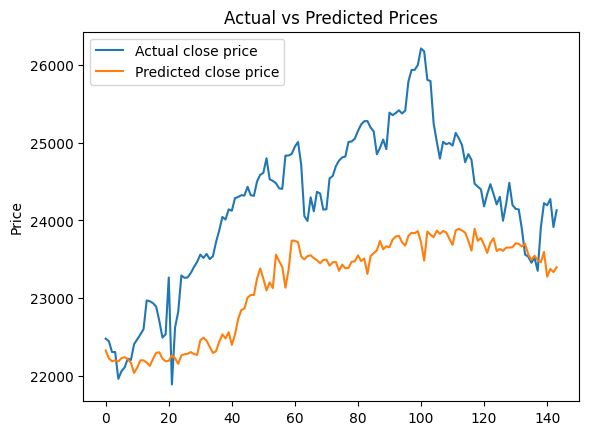

In [82]:
# Plot for Nifty50 share price
plt.plot(target_scaler.inverse_transform(targets_test.reshape(-1,1)), label='Actual close price')
plt.plot(target_scaler.inverse_transform(predictions.reshape(-1,1)), label='Predicted close price')

plt.title('Actual vs Predicted Prices')
plt.ylabel('Price')
plt.legend()

plt.show()

In [83]:
# Calculate MAE on test data
mae = mean_absolute_error(targets_test, predictions)
print(f"Mean Absolute Error: {mae}")

Mean Absolute Error: 0.08699771223456058


In [84]:
targets_test_inv = target_scaler.inverse_transform(targets_test.reshape(-1,1))
predictions_inv = target_scaler.inverse_transform(predictions.reshape(-1,1))
mae = mean_absolute_error(targets_test_inv, predictions_inv)
print(f"Mean Absolute Error of inverse transformed data is : {mae}")

Mean Absolute Error of inverse transformed data is : 1036.9820421006943


In [86]:
model.save("transformer_model_t2v.h5")